## Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors
import matplotlib.animation as animation
import matplotlib.font_manager as font_manager
osfont = font_manager.FontProperties(family='Open Sans', style='normal', size=60)
import geopandas as gpd
# from pysal.contrib.viz import mapping as maps
from shapely.geometry import Point, Polygon, shape
import re
from IPython.display import IFrame
from geopandas import GeoDataFrame
import shapely.speedups
from glob import glob
from shapely import wkt
from shapely.geometry.multipolygon import MultiPolygon
%matplotlib inline

crs = {'init': 'epsg:4326'}
amersfoort = {'init': 'epsg:28992'}
cea = {'proj': 'cea'}

## datasets inladen

In [3]:
#import dataframes buurt
df_buurt = pd.read_csv("GEBIED_BUURTEN_EXWATER.csv",  delimiter=';')
df_buurt = df_buurt[df_buurt.Buurtcombinatie_code != 'N73']
df_buurt = df_buurt[df_buurt.Buurt_code != 'B10g']
df_buurt = df_buurt[df_buurt.Buurt_code != 'B10f']
df_buurt = df_buurt[df_buurt.Buurt_code != 'B10d']
df_buurt = df_buurt[df_buurt.Buurt_code != 'B10c']
df_buurt['buurt_oppervlakte'] = (df_buurt['Opp_m2']/1000000)
#convert dataframes into geodataframes
geometry = df_buurt['WKT_LNG_LAT'].apply(wkt.loads)
gdf_buurt = GeoDataFrame(df_buurt, crs=crs, geometry=geometry)
gdf_buurt = gdf_buurt.to_crs(amersfoort)
gdf_buurt.crs = amersfoort

In [4]:
# overlay amsterdam; hier maak ik de stadsgrenzen van Amsterdam aan
amsterdam = gdf_buurt.geometry.unary_union
df_amsterdam = pd.DataFrame([[amsterdam]])
df_amsterdam['geometry'] = ''
df_amsterdam['geometry'] = df_amsterdam.geometry.apply(lambda x: amsterdam)
df_amsterdam = df_amsterdam.drop([0], axis=1)
gdf_amst = GeoDataFrame(df_amsterdam, geometry='geometry')
gdf_amst.crs = amersfoort

In [5]:
# onbegroeid inladen
gdf_onbegroeid = gpd.read_file('bgt_onbegroeidterreindeel.GeoJSON')
gdf_onbegroeid = gdf_onbegroeid.drop(['relatieveHoogteligging', 'LV-publicatiedatum', 'inOnderzoek', 'tijdstipRegistratie', 'namespace', 'lokaalID', 'bronhouder', 'bgt-status', 'plus-status', 'onbegroeidTerreindeelOpTalud', 'plus-fysiekVoorkomen', 'kruinlijnOnbegroeidTerreindeel', 'eindRegistratie', 'terminationDate'], axis=1)

In [6]:
# Braak inladen; braak gebieden zijn onbegroeide terreinen met het type onverhard.
gdf_braak = gdf_onbegroeid[gdf_onbegroeid['bgt-fysiekVoorkomen'] == 'onverhard']
gdf_braak = GeoDataFrame(gdf_braak, crs=amersfoort)
gdf_braak = gdf_braak.to_crs(cea)
gdf_braak.crs = cea
gdf_braak["oppervlakte"] = gdf_braak['geometry'].area/1000000
gdf_braak = gdf_braak.to_crs(amersfoort)
gdf_braak.crs = amersfoort

In [8]:
# Bomen inladen; hier worden ook de boomgroottes/oppervlaktes gedefineerd en alles in de goeie crs gezet.
def to_crs(gdf, crs=amersfoort):
    gdf = gdf.to_crs(crs)
    gdf.crs = crs
    return gdf

def create_gdf(df, crs=crs):
    gdf = GeoDataFrame(df, crs=crs, geometry=df.geometry.apply(wkt.loads))
    return to_crs(gdf, crs=amersfoort)
# groteboom_m2 
n1 = 18.7
# middelboom_m2 
n2 = 14.3
# kleineboom_m2 
n3 = 10.5
# microbosje
nbos = 280

bomen = pd.concat([pd.read_csv(file, sep=';', usecols=['Soortnaam_NL', 'Boomnummer', 'Boomtype', 'Boomhoogte', 'WKT_LNG_LAT']) 
                   for file in glob('BOMEN*.csv')], axis=0, ignore_index=True).rename(columns={'WKT_LNG_LAT':'geometry'})
bomen['geometry'] = bomen.geometry.str.replace(',', ' ')
bomen['aantal_bomen'] = 1
bomen['boomoppervlakte'] = np.where(bomen['Boomhoogte'].isin(['tot 6 m', '6-9 m', '9-12 m', 'Onbekend']), n3/1000000, 
                                    np.where(bomen['Boomhoogte'].isin(['12-15 m', '15-18 m']), n2/1000000, n1/1000000))
bomen = create_gdf(bomen)

In [9]:
# Panden inladen
pand = pd.read_csv('buildings.csv', sep=',').drop(['Unnamed: 0'], axis = 1)
pand['geometry'] = pand['geometry'].apply(wkt.loads)
pand = GeoDataFrame(pand, crs=amersfoort)
pand['aantal_panden'] = 1
pand = pand.to_crs(cea)
pand.crs = cea
pand['pand_oppervlakte'] = pand['geometry'].area/1000000
pand = pand.to_crs(amersfoort)
pand.crs = amersfoort

In [10]:
# Bestemmingsplannen inladen en overlay met stadsgrenzen
gdf_bestemming = pd.read_csv("bestemmingsplan.csv",  delimiter=',')
gdf_bestemming['geometry'] = gdf_bestemming['geometry'].apply(wkt.loads)
gdf_bestemming = GeoDataFrame(gdf_bestemming, crs=crs)
gdf_bestemming = gdf_bestemming.to_crs(cea)
gdf_bestemming.crs = cea
gdf_bestemming['b_area'] = gdf_bestemming['geometry'].area/1000000
gdf_bestemming = gdf_bestemming.to_crs(amersfoort)
gdf_bestemming.crs = amersfoort
gdf_bestemming = gdf_bestemming[gdf_bestemming.Fase.isin(['Principebesluit genomen','Overkoepelend besluit genomen'])]
gdf_bestemming = gpd.overlay(gdf_bestemming, gdf_amst, how='intersection')

## Braak joinen op buurt

In [11]:
# Overlay buurten en bestemmingplannen; eerst alles binnen stadsgrenzen dan binnen buurten. 
# Vervolgens wordt alles binnen een bestemmingsplan eraf gehaald.
gdf_temp = gpd.overlay(gdf_braak, gdf_amst, how='intersection')
gdf_temp2 = gpd.overlay(gdf_braak, gdf_buurt, how='intersection')
dfg_braak_stad = gpd.overlay(gdf_temp2, gdf_bestemming, how='difference')

In [12]:
# nieuwe area uitrekenen (na overlay)
dfg_braak_stad = dfg_braak_stad.dissolve(by='Buurt')
dfg_braak_stad = dfg_braak_stad.reset_index()
dfg_braak_stad = dfg_braak_stad.to_crs(cea)
dfg_braak_stad.crs = cea
dfg_braak_stad["oppervlakte"] = dfg_braak_stad['geometry'].area/1000000
dfg_braak_stad = dfg_braak_stad.to_crs(amersfoort)
dfg_braak_stad.crs = amersfoort
dfg_braak_stad = dfg_braak_stad.reset_index()
dfg_braak_stad['terrein_id'] = dfg_braak_stad['index']
dfg_braak_stad = dfg_braak_stad.drop(['index'], axis=1)

## Objecten binnen stadsgrenzen

In [13]:
# Bomen & pand binnen stadsgrenzen doormiddel van een spacial join
bomen_stad = gpd.sjoin(bomen, dfg_braak_stad, how='inner', op='within').drop(['index_right', 'gml_id', 'creationDate', 'bgt-fysiekVoorkomen', 'oppervlakte', 'OBJECTNUMMER', 'Buurt_code', 'Buurt', 'Buurtcombinatie_code', 'Stadsdeel_code', 'buurt_oppervlakte', 'WKT_LNG_LAT', 'terrein_id','oppervlakte'], axis = 1)
pand_stad = gpd.sjoin(pand, gdf_buurt, how='inner', op='within').drop(['index_right', 'OBJECTNUMMER', 'Buurt_code', 'Buurt', 'Buurtcombinatie_code', 'Stadsdeel_code', 'buurt_oppervlakte', 'WKT_LNG_LAT', 'WKT_LAT_LNG', 'LNG', 'LAT', 'Unnamed: 10'], axis = 1)

C:\Users\PSaalbrink\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


## Test plot

In [ ]:
# fig, ax = plt.subplots(1, figsize=(50, 60))
# # plt.title('Braakliggende terreinen, panden & bomen', size=80)
# gdf_buurt.plot(linewidth=3, ax=ax, edgecolor='0.3', color='white')
# gdf_temp2.plot(ax=ax, color='purple')
# dfg_braak_stad.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=4)
# gdf_bestemming.plot(ax=ax, edgecolor='red', linewidth=4, facecolor='none')
# pand_stad.plot(linewidth=0.5, ax=ax, edgecolor='black', facecolor='none')
# bomen_stad.plot(ax=ax, linewidth=2, edgecolor='green', facecolor='none', markersize=10)
# plt.axis('off')
# fig.savefig('bomen_amsterdam.png', bbox_inches='tight');

## Joinen van braak met bomen en panden (uitrekenen oppervlakte objecten per braak)

In [15]:
# joinen van bomen en panden. Zo kan je zien hoeveel objecten er binnen een braak gebied vallen
gdf_braak_bomen = gpd.sjoin(dfg_braak_stad, bomen_stad, how='left', op='contains').groupby(['terrein_id']).sum()
gdf_braak_panden = gpd.sjoin(dfg_braak_stad, pand_stad, how='left', op='contains').groupby(['terrein_id']).sum()
gdf_braak_panden = gdf_braak_panden.reset_index()
gdf_braak_bomen = gdf_braak_bomen.reset_index()

## mergen van oppervlaktes + vrije ruimte uitrekenen

In [17]:
# Oppervlakte van braakliggende gebieden matchen aan die van bomen en panden.
# Eerst bomen en panden mergen, vervolgens mergen met het originele braak bestand voor het juiste oppervlakte.
gdf_braak_panden_bomen_temp = gdf_braak_bomen.merge(gdf_braak_panden, on=['terrein_id'])
# .drop(['OBJECTNUMMER_x','area','buurt_oppervlakte_x','OBJECTNUMMER_y','buurt_oppervlakte_y', 'Unnamed: 10_left', 'Unnamed: 10_right', 'index_right_x', 'index', 'oppervlakte_y', 'Unnamed: 10', 'index_right_y'], axis=1)
gdf_braak_panden_bomen = dfg_braak_stad.merge(gdf_braak_panden_bomen_temp, on=['terrein_id'])

# Vrije ruimte uitrekenen
gdf_braak_panden_bomen['vrije_ruimte'] = gdf_braak_panden_bomen['oppervlakte']-(gdf_braak_panden_bomen.boomoppervlakte + gdf_braak_panden_bomen.pand_oppervlakte)
gdf_braak_panden_bomen['vrije_ruimte'] = np.where(gdf_braak_panden_bomen['vrije_ruimte']<=0, 0,gdf_braak_panden_bomen['vrije_ruimte'])

## Te planten bomen uitrekenen

In [18]:
# Door de rest waarde uit te rekenen kan er gekeken worden hoeveel kleine/middel boven er nog geplaatst kunnen worden wanneer alle grote bomen geplant zijn.
gdf_braak_panden_bomen['rest'] = gdf_braak_panden_bomen['vrije_ruimte'] % (n1/1000000)
gdf_braak_panden_bomen['te_planten_grote_bomen'] = (gdf_braak_panden_bomen['vrije_ruimte'] - gdf_braak_panden_bomen['rest'])/(n1/1000000)
gdf_braak_panden_bomen['te_planten_grote_bomen'] = np.where(gdf_braak_panden_bomen['te_planten_grote_bomen']<1, 0,gdf_braak_panden_bomen['te_planten_grote_bomen'])
gdf_braak_panden_bomen['te_planten_grote_bomen'] = gdf_braak_panden_bomen['te_planten_grote_bomen'].astype(int).round(0)
gdf_braak_panden_bomen['te_planten_middel_bomen'] = np.where(gdf_braak_panden_bomen['rest'] >= (n2/1000000), 1,0)
gdf_braak_panden_bomen['te_planten_klein_bomen'] = np.where(np.logical_and(gdf_braak_panden_bomen['rest'] >= (n3/1000000), gdf_braak_panden_bomen['rest'] < (n2/1000000)), 1,0)
gdf_braak_panden_bomen['aantal_microbos'] = (gdf_braak_panden_bomen['te_planten_grote_bomen']/(nbos/n1)).astype(int).round(0)
gdf_braak_panden_bomen['te_planten_bomen_totaal'] = gdf_braak_panden_bomen['te_planten_klein_bomen'] + gdf_braak_panden_bomen['te_planten_middel_bomen'] + gdf_braak_panden_bomen['te_planten_grote_bomen'] 
gdf_braak_panden_bomen = gdf_braak_panden_bomen.drop(['rest'], axis=1)
gdf_braak_panden_bomen = gdf_braak_panden_bomen[gdf_braak_panden_bomen.te_planten_bomen_totaal > 0]

## Terrein top 10

In [ ]:
# gdf_braak_panden_bomen.head()

In [ ]:
terrein_top_10 = gdf_braak_panden_bomen.sort_values(['te_planten_bomen_totaal'], ascending=False).head(10).drop(['creationDate','OBJECTNUMMER','Buurt_code','Buurtcombinatie_code', 'WKT_LNG_LAT', 'WKT_LAT_LNG', 'LNG', 'LAT', 'oppervlakte', 'oppervlakte_x', 'Boomnummer', 'pand_id','Opp_m2_left_x', 'Opp_m2_left_y', 'Opp_m2_right_y', 'Opp_m2_right_x', 'Opp_m2' ], axis=1)
# terrein_top_10.to_csv('Terreinen_top_10.csv')
# terrein_top_10

## Buurt top 10

In [ ]:
buurt_top_10 = gdf_braak_panden_bomen.groupby(['Buurt']).sum().sort_values(['te_planten_bomen_totaal'], ascending=False).head(10).drop(['OBJECTNUMMER', 'terrein_id', 'Boomnummer', 'pand_id', 'oppervlakte_x', 'oppervlakte', 'Opp_m2_left_x', 'Opp_m2_right_x', 'Opp_m2_left_y', 'Opp_m2_right_y' ,'Opp_m2'], axis=1)
# buurt_top_10.to_csv('buurten_top_10.csv')
# buurt_top_10

In [23]:
gdf_braak_panden_bomen.te_planten_bomen_totaal.sum()

101294

In [24]:
gdf_braak_panden_bomen.vrije_ruimte.sum()

1.8947353256644834

## Aantal parkjes

In [25]:
# Aantal bomen dat een park vormt
parkgrootte = 500
aantal_parkjes = len(gdf_braak_panden_bomen[gdf_braak_panden_bomen.te_planten_bomen_totaal > parkgrootte])
aantal_parkjes

43

## Plots

In [26]:
# inladen stadsdelen
stadsdelen = pd.read_csv('GEBIED_STADSDELEN_EXWATER.csv', delimiter=';').rename(columns={'WKT_LNG_LAT': 'geometry'})
stadsdelen = GeoDataFrame(stadsdelen, crs=crs, geometry=stadsdelen.geometry.apply(wkt.loads))
stadsdelen = stadsdelen.to_crs(amersfoort)
stadsdelen.crs = amersfoort

In [27]:
# kies stadsdeel op index: {0=centrum, 1=westpoort, 2=zuidoost, 3=west, 4=nieuw-west, 5=oost, 6=zuid, 7=noord} 
deelindex = 4
gdf_braak_stadsdeel = gdf_braak_panden_bomen[gdf_braak_panden_bomen.geometry.within(stadsdelen.geometry[deelindex])]
gdf_buurt_stadsdeel= gdf_buurt[gdf_buurt.geometry.within(stadsdelen.geometry[deelindex])]
bomen_stadsdeel = bomen[bomen.geometry.within(stadsdelen.geometry[deelindex])]
panden_stadsdeel = pand_stad[pand_stad.geometry.within(stadsdelen.geometry[deelindex])]
temp_stadsdeel = gdf_temp2[gdf_temp2.geometry.within(stadsdelen.geometry[deelindex])] 
bestem_stadsdeel =  gpd.overlay(gdf_bestemming, stadsdelen[stadsdelen.index == deelindex], how='intersection')

In [ ]:
# # Plot per stadsdeel 
# fig, ax = plt.subplots(1, figsize=(60, 80))
# gdf_buurt_stadsdeel.plot(linewidth=3, ax=ax, edgecolor='0.3', color='white')
# # temp_stadsdeel.plot(ax=ax, color='purple', linewidth=10, markersize=40, alpha=0.3)
# gdf_braak_stadsdeel.plot(ax=ax, edgecolor='purple', linewidth=4, facecolor='none')
# bomen_stadsdeel.plot(linewidth=2, ax=ax, edgecolor='green', facecolor='none', markersize=100)
# panden_stadsdeel.plot(linewidth=.5, ax=ax, edgecolor='black', facecolor='none')
# bestem_stadsdeel.plot(ax=ax, edgecolor='blue', linewidth=4, alpha=0.5)

# # Legend
# leg_0 = patches.Patch(
#     edgecolor='purple', facecolor='none', linewidth=4, 
#     label=f"Wastelands")
# leg_1 = patches.Patch(
#     color='#2ca02c', 
#     label=f"Existing Trees ({bomen_stadsdeel.aantal_bomen.sum():,})")
# plt.legend(handles=[leg_0, leg_1], prop=osfont, fancybox=True)
# plt.axis('off')
# fig.savefig('nieuwwest braakliggende terreinen.png', bbox_inches='tight');

## Nieuwe bomen plot

In [60]:
import random
import shapely
import geopandas
import pandas as pd
from shapely.geometry import Point, LineString
from geopandas import GeoDataFrame, GeoSeries

# Definieer projecties
crs = {'init': 'epsg:4326'}          # Standaard WGS84
amersfoort = {'init': 'epsg:28992'}  # Rijkscoördinatendriehoek
cea = {'proj':'cea'}                 # Equal area

# Functies definiëren


def random_points_within(poly, k, min_dist=0):
    '''Returns a list of lists of k random Point objects that are within poly, seperated by at least min_dist'''
    min_x, min_y, max_x, max_y = poly.bounds
    points = []
    i = 0
    while len(points) < k:
        i += 1
        # Pak een random punt op de x-as, en vind en een random punt op de y-as dat in het polygoon ligt
#         try:
#             x = random.uniform(min_x, max_x)
#             x_line = LineString([(x, min_y), (x, max_y)])
#             x_line_intercept_min, x_line_intercept_max = x_line.intersection(poly).xy[1].tolist()
#             y = random.uniform(x_line_intercept_min, x_line_intercept_max)
#         except:
#             continue
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))  # Point([x, y])
        # Controleer of de afstand van een nieuwe boom tot bestaande bomen kleiner is dan min_dist
        # (Dit werkt nog niet goed wanneer min_dist te groot is)
        dist = []
        gdf = GeoDataFrame(points, crs=cea)
        for ind in range(len(gdf)):
            dist.append(gdf.iat[ind, 0].distance(point) < min_dist)  # bool
        # Voeg de nieuwe boom toe, behalve als er een andere nieuwe boom dichterbij ligt dan min_dist
        if sum(dist) == 0 and poly.contains(point):
            points.append(point)
        elif i > k * 10:
            return points
        else:
            continue
    return points

def random_points(row, colname='nieuwe_bomen', min_dist=0):
    '''Returns a list of lists of random points, 
    based on a geometry and a value of nieuwe_bomen in a GeoDataFrame'''
    points = random_points_within(row['geometry'], row[colname], min_dist=min_dist)
    return points

def plant_trees(gdf, colname='nieuwe_bomen', min_dist=0):
    '''Returns a GeoSeries (with epsg:28992) of random points within each geometry of a GeoDataFrame'''
    # change gdf.crs to cea for equal area calculations 
    # get a list of lists of random points within gdf.geometry
    # transform into a Series, then a GeoSeries, and change crs to epsg:28992
    return to_crs(GeoSeries(pd.Series(to_crs(gdf, cea).apply(
        random_points, colname=colname, min_dist=min_dist, axis=1)).apply(
        lambda x: pd.Series(x)).stack().tolist(), crs=cea), amersfoort)


# Functies aanroepen

# Ik ga er hier van uit dat je een GeoDataFrame hebt met een kolom 'geometry' die bestaat uit Polygons
# en een kolom 'Buurt' met buurtnamen

# Maak subset van de wegen-data om te kunnen plotten
tmp = gdf_braak_stadsdeel
# tmp['te_planten_bomen_totaal'] = tmp.te_planten_bomen_totaal.astype(int)

# Maak een GeoSeries met nieuwe bomen om te kunnen plotten
geo = plant_trees(tmp, colname='te_planten_grote_bomen', min_dist=2.44)

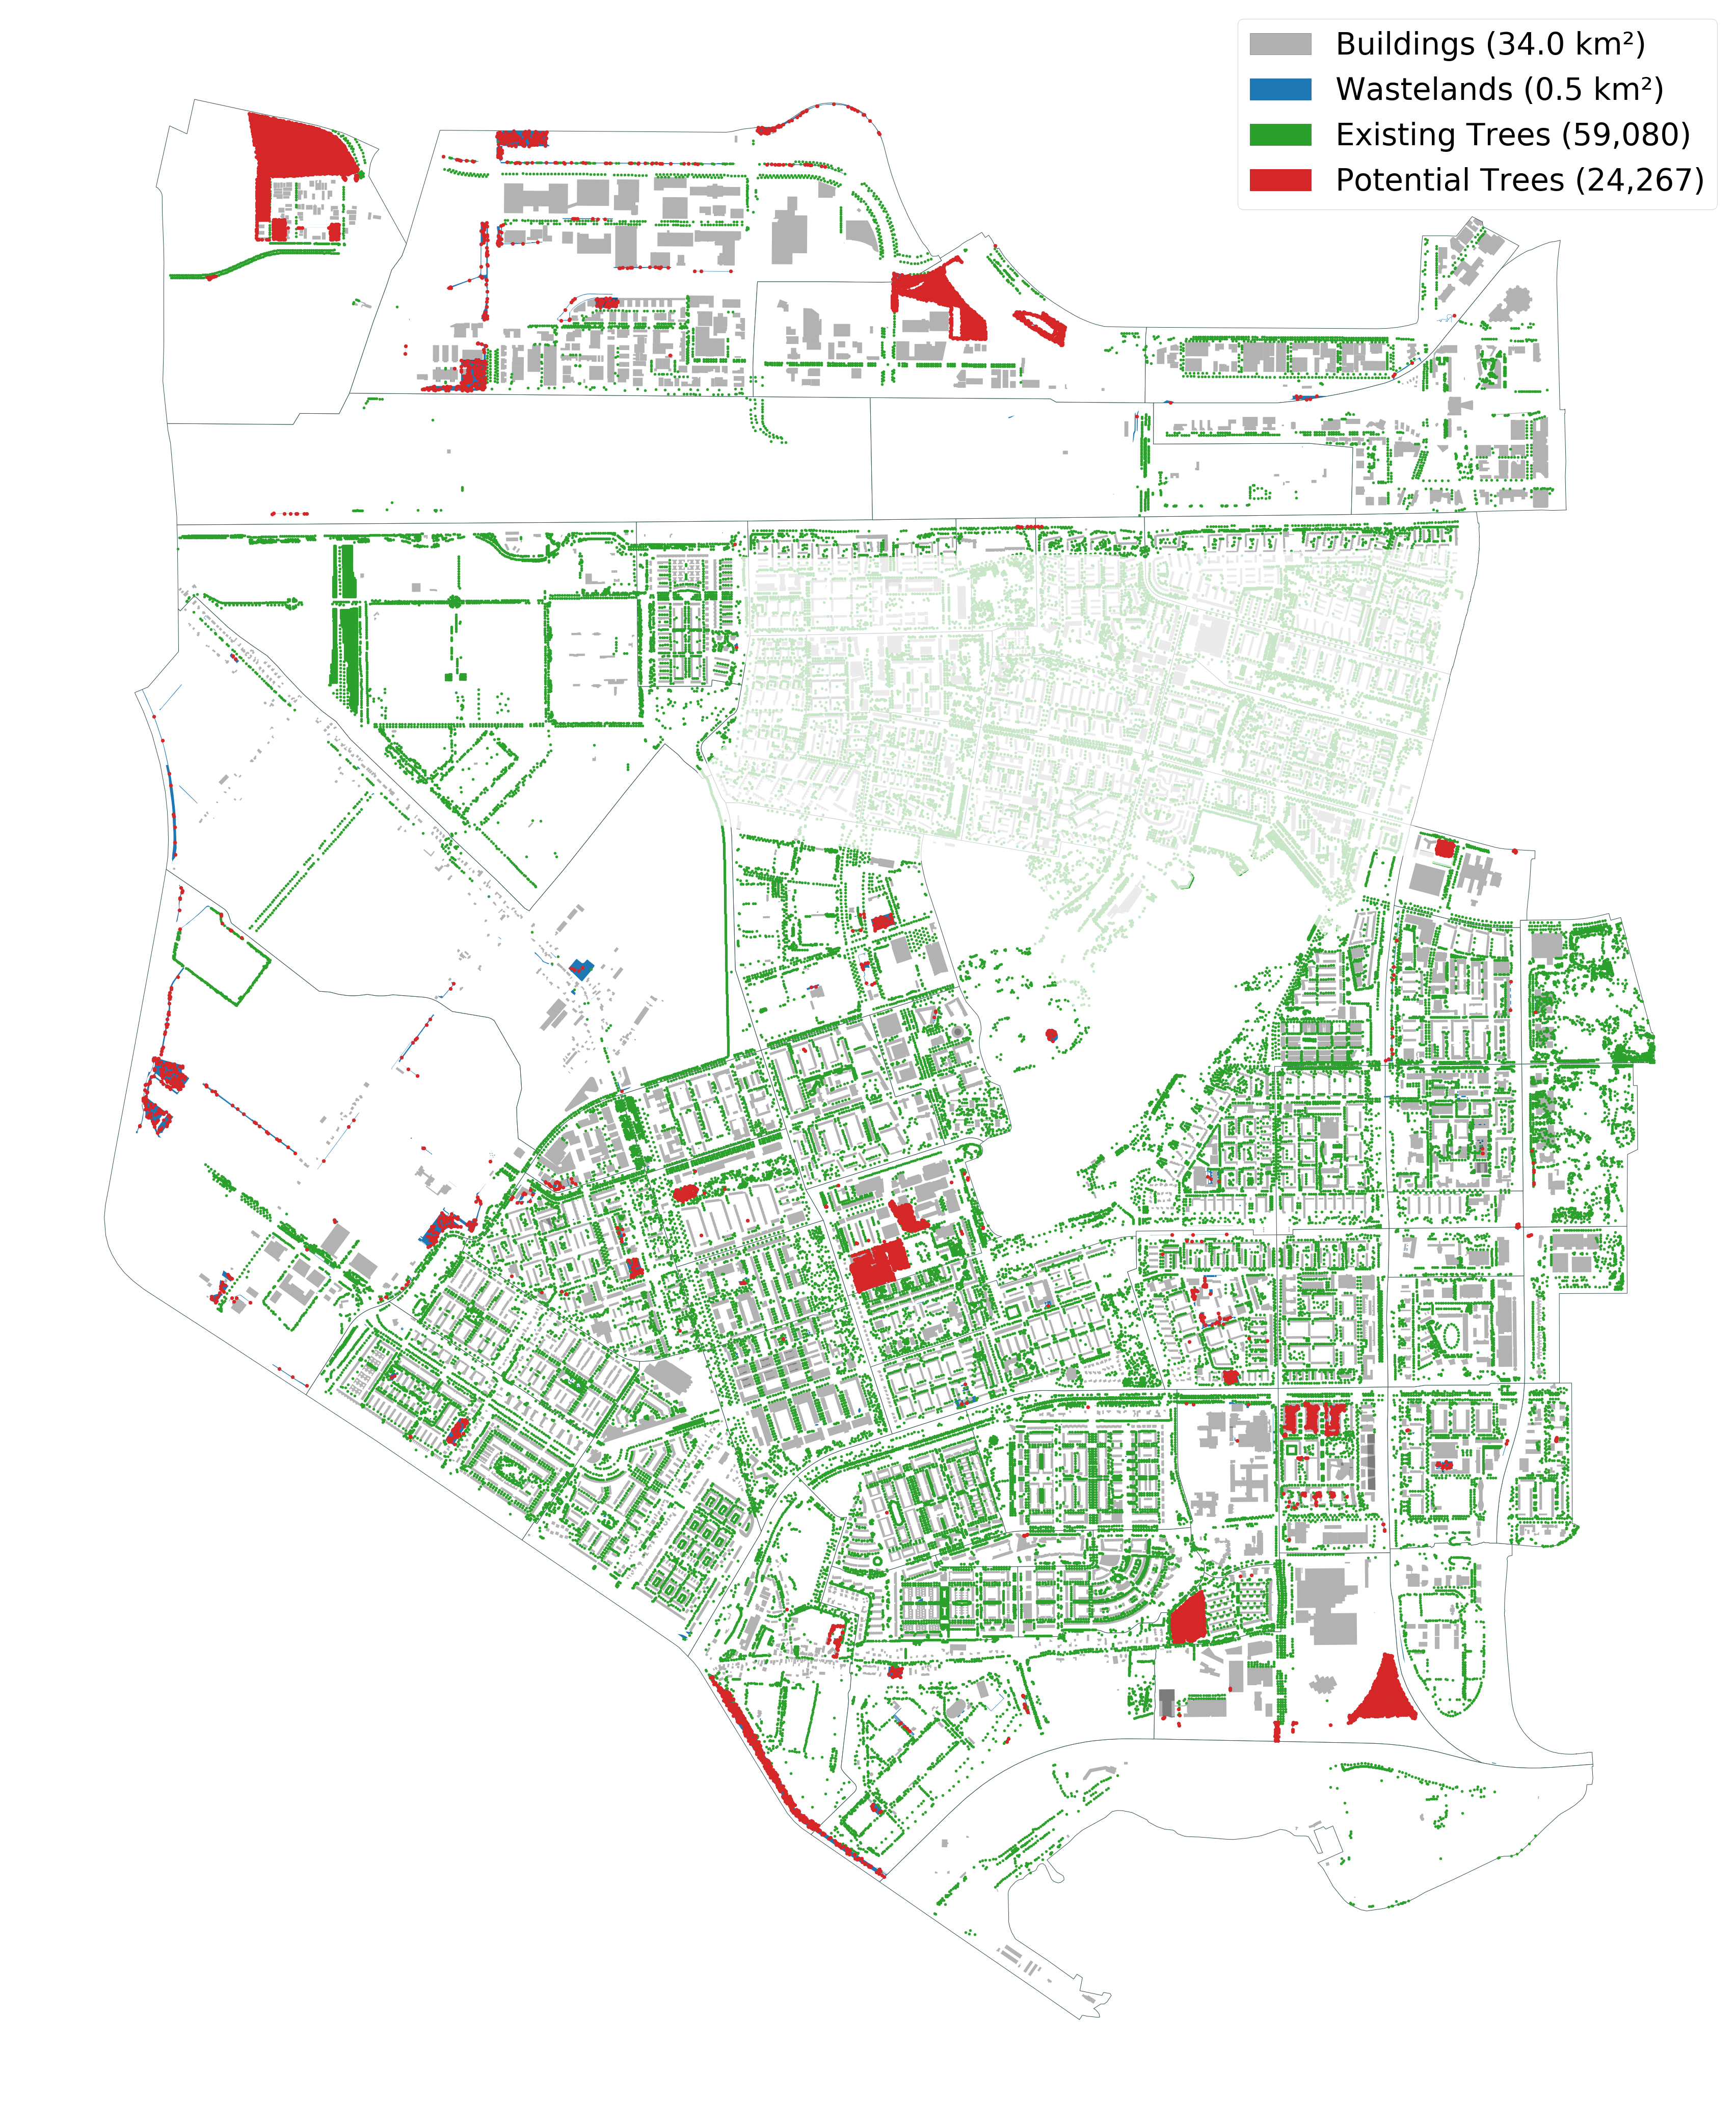

In [66]:
# Plot per stadsdeel 

fig, ax = plt.subplots(1, figsize=(60, 80))


gdf_buurt_stadsdeel.plot(ax=ax, linewidth=1, edgecolor='darkslategrey', color='white')  # buurtgrenzen

gdf_braak_stadsdeel.plot(ax=ax, color='#1f77b4')  # leg_1

panden_stadsdeel.plot(ax=ax, color='black', alpha=0.3)  # leg_0

bomen_stadsdeel.plot(ax=ax, color='#2ca02c', markersize=20)  # leg_2

bestem_stadsdeel.plot(ax=ax, color='white', alpha=0.75)  # uitgesloten bestemmingsgebied

geo.plot(ax=ax, color='#d62728', markersize=40)  # leg_3


# Legend
leg_0 = patches.Patch(
    color='black', alpha=0.3, 
    label=f"Buildings ({gdf_buurt_stadsdeel.buurt_oppervlakte.sum():.1f} km²)")
leg_1 = patches.Patch(
    color='#1f77b4', 
    label=f"Wastelands ({gdf_braak_stadsdeel.oppervlakte.sum():.1f} km²)")
leg_2 = patches.Patch(
    color='#2ca02c', 
    label=f"Existing Trees ({bomen_stadsdeel.aantal_bomen.sum():,})")
leg_3 = patches.Patch(
    color='#d62728', 
    label=f"Potential Trees ({gdf_braak_stadsdeel.te_planten_bomen_totaal.sum():,})")


plt.legend(handles=[leg_0, leg_1, leg_2, leg_3], prop=osfont, fancybox=True)

plt.axis('off')
fig.savefig('nieuwwest braakliggende terreinen.png', bbox_inches='tight');